In [ ]:
!pip3 install numpy pandas matplotlib
import os
import numpy as np
import pandas as pd
import re

In [ ]:
if 'TIRA_DATASET_ID' not in os.environ:
    !pip3 install python-terrier tira==0.0.88
else:
    print('We are in the TIRA sandbox.')

In [ ]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run

# this loads and starts pyterrier so that it also works in the TIRA
ensure_pyterrier_is_loaded()

# PyTerrier must be imported after the call to ensure_pyterrier_is_loaded in TIRA.
import pyterrier as pt

### Herausfinden des Schwellwerts

In [77]:
df = pd.read_xml("topics-anonymized.xml")
df.head()

,number,title,description,narrative
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe..."
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...


In [78]:
df["length"] = df["title"].map(lambda x: len(x))
df["word_count"] = df["title"].map(lambda x: x.count(" ")+1)
df.head()

,number,title,description,narrative,length,word_count
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,71,12
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",27,4
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,25,4
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,18,3
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,13,3


array([[<Axes: title={'center': 'length'}>]], dtype=object)

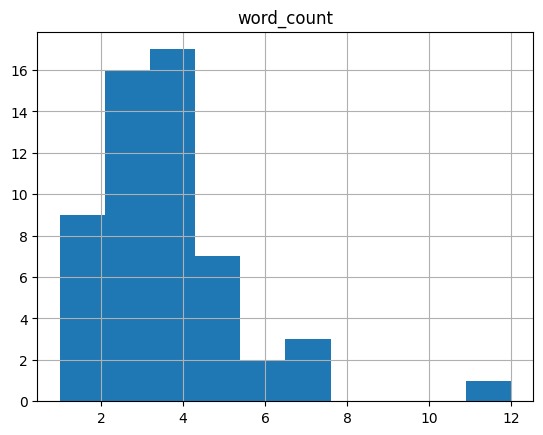

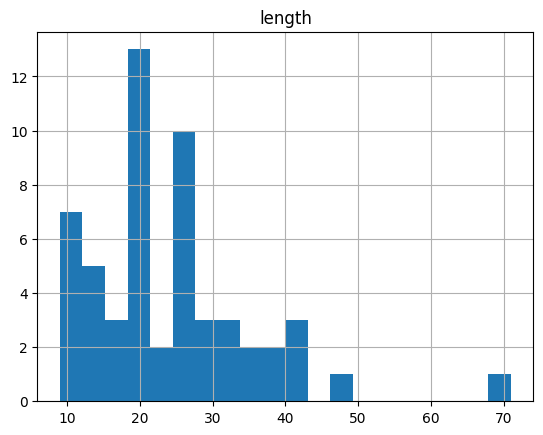

In [79]:
df.hist(column="word_count")
df.hist(column="length", bins=20)

In [82]:
median = df["word_count"].median()
groups_df = pd.DataFrame({f"median = {median}": ["below", "above"], 
                           "set size": [len(df[df["word_count"] < median]), len(df[df["word_count"] > median])], 
                           "include equal": [len(df[df["word_count"] <= median]), len(df[df["word_count"] >= median])]})
groups_df = groups_df.style.highlight_max("set size", props="font-weight: bold").highlight_min("include equal", props="font-weight: bold")
groups_df

,median = 4.0,set size,include equal
0,below,25,42
1,above,13,30


### Index bauen

In [83]:
data = pt.get_dataset('irds:ir-lab-jena-leipzig-wise-2023/validation-20231104-training')

In [ ]:
print('Build index:')
iter_indexer = pt.IterDictIndexer("/tmp/index", meta={'docno': 100}, verbose=True)
!rm -Rf /tmp/index
indexref = iter_indexer.index(data.get_corpus_iter())
print('Done. Index is created')

### Unsere Retrieval Pipeline

In [84]:
bo1 = pt.rewrite.Bo1QueryExpansion(indexref, verbose=True)
bm25 = pt.BatchRetrieve(indexref, wmodel="BM25", verbose=True)
qe_pipeline = ~(bm25 >> bo1 >> bm25)
non_qe_pipeline = ~(bm25)

In [85]:
topics = data.get_topics()
topics.head()

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


,qid,text,title,query,description,narrative
0,q072224,purchase money,purchase money,purchase money,None,None
1,q072226,purchase used car,purchase used car,purchase used car,None,None
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None
3,q072240,adenovirus,adenovirus,adenovirus,None,None
4,q072242,Water softener,Water softener,water softener,None,None


In [89]:
# Calculation of the number of words in the title
topics["word_count_old"] = topics["title"].map(lambda x: x.count(" ")+1)
# Calculation of the number of characters in the title
topics["length"] = topics["title"].map(lambda x: len(x))

# Calculation of the number of words in the title using the pyterrier tokenizer
# https://pyterrier.readthedocs.io/en/latest/text.html#working-with-passages-rather-than-documents : r'\s+' instead of ' '
topics["word_count"] = topics["title"].map(lambda x: len(re.split(r'\s+', x)))

topics.head()

,qid,text,title,query,description,narrative,word_count_old,word_count,length,is_long
0,q072224,purchase money,purchase money,purchase money,None,None,2,2,14,False
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,3,17,True
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,3,15,True
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,1,10,False
4,q072242,Water softener,Water softener,water softener,None,None,2,2,14,False


In [88]:
# Calulation of the Threshold
topics["word_count"] = topics["title"].map(lambda x: x.count(" ")+1)
threshold = topics["word_count"].median()
if len(topics[topics["word_count"] > threshold]) > len(topics[topics["word_count"] < threshold]):
    topics["is_long"] = topics["word_count"] > threshold
else:
    topics["is_long"] = topics["word_count"] >= threshold

In [18]:
# Experiment over all topics and the two pipelines
experiment = pt.Experiment(
    [qe_pipeline, non_qe_pipeline],
    topics, data.get_qrels(),
    ["ndcg_cut_5"],
    ["mit QE", "ohne QE"],
    perquery=True
)

No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/paul/.tira/.tira-settings.json. I will use defaults.


BR(BM25): 100%|██████████| 878/878 [00:15<00:00, 57.19q/s]


In [19]:
# merge the topics with the results
eval_all = experiment.merge(topics, on="qid")
eval_all.head()

,name,qid,measure,value,text,title,query,description,narrative,word_count_old,word_count,length,is_long
0,mit QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,3,18,True
1,ohne QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,3,18,True
2,mit QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,2,15,False
3,ohne QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,2,15,False
4,mit QE,q072210114,ndcg_cut_5,0.0,Thermal curtain,Thermal curtain,thermal curtain,None,None,2,2,15,False


In [20]:
# combine the results of the two pipelines into one dataframe
without_qe = eval_all[eval_all["name"] == "ohne QE"][["qid", "value"]]
with_qe = eval_all[eval_all["name"] == "mit QE"][["qid", "value"]]

eval = topics.copy()
eval["ndcg_without_qe"] = eval["qid"].map(without_qe.set_index("qid")["value"])
eval["ndcg_with_qe"] = eval["qid"].map(with_qe.set_index("qid")["value"])

eval.head()

,qid,text,title,query,description,narrative,word_count_old,word_count,length,is_long,ndcg_without_qe,ndcg_with_qe
0,q072224,purchase money,purchase money,purchase money,None,None,2,2,14,False,0.000000,0.0
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,3,17,True,0.000000,0.0
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,3,15,True,0.000000,0.0
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,1,10,False,0.351239,0.0
4,q072242,Water softener,Water softener,water softener,None,None,2,2,14,False,0.264068,0.0


In [91]:
# calculate the improvement (TODO check if other metrics for improvement are better)
eval["diff_improvement"] = eval["ndcg_with_qe"] - eval["ndcg_without_qe"]
eval["prop_improvement"] = (eval["diff_improvement"] / eval["ndcg_without_qe"]).where(abs(eval["diff_improvement"]) >= 1e-9, 0.0)
# using 0.0 instead of NaN if there is no improvement
eval.head()

,qid,text,title,query,description,narrative,word_count_old,word_count,length,is_long,ndcg_without_qe,ndcg_with_qe,diff_improvement,prop_improvement
0,q072224,purchase money,purchase money,purchase money,None,None,2,2,14,False,0.000000,0.0,0.000000,0.0
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,3,17,True,0.000000,0.0,0.000000,0.0
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,3,15,True,0.000000,0.0,0.000000,0.0
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,1,10,False,0.351239,0.0,-0.351239,-1.0
4,q072242,Water softener,Water softener,water softener,None,None,2,2,14,False,0.264068,0.0,-0.264068,-1.0


array([[<Axes: title={'center': 'prop_improvement'}>]], dtype=object)

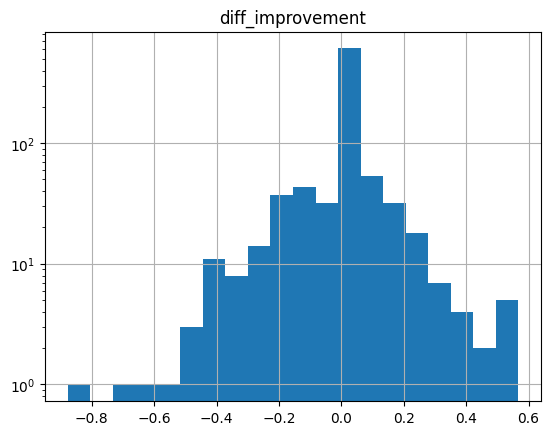

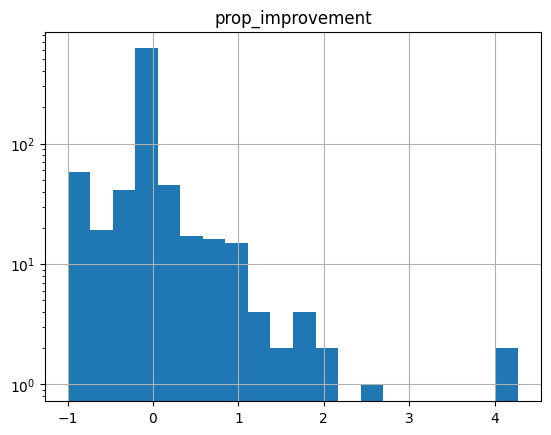

In [90]:
eval.hist(column="diff_improvement", bins=20, log=[True, False])
eval[eval["prop_improvement"] != float('inf')].hist(column="prop_improvement", bins=20, log=[True, False])

In [92]:
# average diff_improvement
eval[["is_long", "diff_improvement"]].groupby("is_long").mean()

,diff_improvement
is_long,
False,-0.009601
True,-0.001440
